In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install --quiet seaborn

You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
!pip install --quiet shap

You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import cv2
import json

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
from sklearn.metrics import confusion_matrix, classification_report

In [10]:
import shap
from operator import itemgetter

In [14]:
my_data_dir = '/data/casting_data/casting_data/casting_data/'
train_path = my_data_dir + 'train/'
test_path = my_data_dir + 'test/'

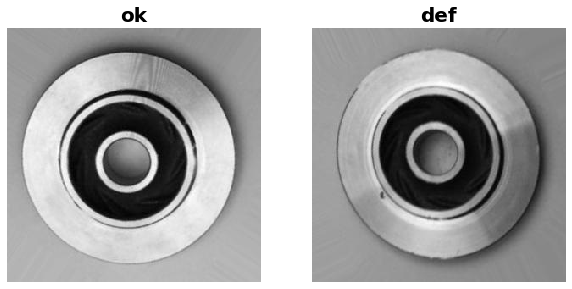

In [15]:
plt.figure(figsize=(10,8))
ok = plt.imread(train_path + 'ok_front/cast_ok_0_1.jpeg')
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("ok", weight='bold', size=20)
plt.imshow(ok,cmap='gray')

ng = plt.imread(train_path + 'def_front/cast_def_0_0.jpeg')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("def", weight='bold', size=20)
plt.imshow(ng,cmap='gray')

plt.show()

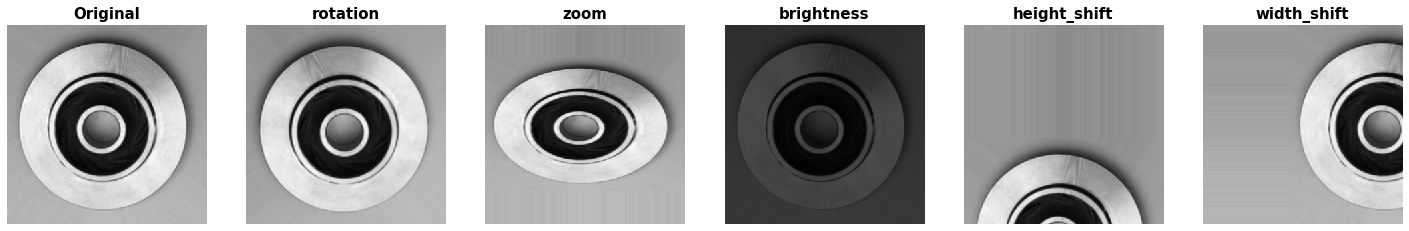

In [16]:
#Image Preprocessing o
img = cv2.imread(train_path + 'ok_front/cast_ok_0_1.jpeg')
img_4d = img[np.newaxis]
plt.figure(figsize=(25,10))
generators = {"rotation":ImageDataGenerator(rotation_range=180), 
              "zoom":ImageDataGenerator(zoom_range=0.7), 
              "brightness":ImageDataGenerator(brightness_range=[0.2,1.0]), 
              "height_shift":ImageDataGenerator(height_shift_range=0.7), 
              "width_shift":ImageDataGenerator(width_shift_range=0.7)}

plt.subplot(1, 6, 1)
plt.title("Original", weight='bold', size=15)
plt.imshow(img)
plt.axis('off')
cnt = 2
for param, generator in generators.items():
    image_gen = generator
    gen = image_gen.flow(img_4d, batch_size=1)
    batches = next(gen)
    g_img = batches[0].astype(np.uint8)
    plt.subplot(1, 6, cnt)
    plt.title(param, weight='bold', size=15)
    plt.imshow(g_img)
    plt.axis('off')
    cnt += 1
plt.show()

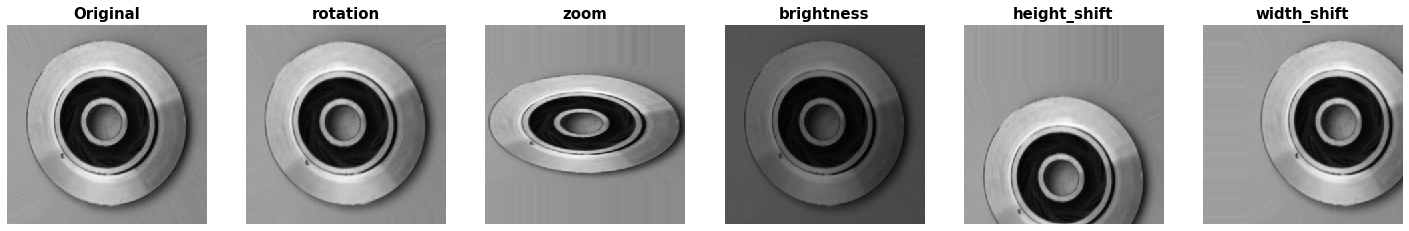

In [17]:
#Image Preprocessing o
img = cv2.imread(train_path + 'def_front/cast_def_0_0.jpeg')
img_4d = img[np.newaxis]
plt.figure(figsize=(25,10))
generators = {"rotation":ImageDataGenerator(rotation_range=180), 
              "zoom":ImageDataGenerator(zoom_range=0.7), 
              "brightness":ImageDataGenerator(brightness_range=[0.2,1.0]), 
              "height_shift":ImageDataGenerator(height_shift_range=0.7), 
              "width_shift":ImageDataGenerator(width_shift_range=0.7)}

plt.subplot(1, 6, 1)
plt.title("Original", weight='bold', size=15)
plt.imshow(img)
plt.axis('off')
cnt = 2
for param, generator in generators.items():
    image_gen = generator
    gen = image_gen.flow(img_4d, batch_size=1)
    batches = next(gen)
    g_img = batches[0].astype(np.uint8)
    plt.subplot(1, 6, cnt)
    plt.title(param, weight='bold', size=15)
    plt.imshow(g_img)
    plt.axis('off')
    cnt += 1
plt.show()

In [18]:
image_gen = ImageDataGenerator(rescale=1/255, 
                               zoom_range=0.1, 
                               brightness_range=[0.9,1.0])

In [19]:
image_shape = (300,300,1) # 300 × 300、graysclaed (full-color : 3)
batch_size = 32

train_set = image_gen.flow_from_directory(train_path,
                                            target_size=image_shape[:2],
                                            color_mode="grayscale",
                                            classes={'def_front': 0, 'ok_front': 1},
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle=True,
                                            seed=0)

Found 6633 images belonging to 2 classes.


In [20]:
test_set = image_gen.flow_from_directory(test_path,
                                           target_size=image_shape[:2],
                                           color_mode="grayscale",
                                           classes={'def_front': 0, 'ok_front': 1},
                                           batch_size=batch_size,
                                           class_mode='binary',
                                           shuffle=False,
                                           seed=0)

Found 699 images belonging to 2 classes.


In [21]:
print (train_set.class_indices)
print (test_set.class_indices)

{'def_front': 0, 'ok_front': 1}
{'def_front': 0, 'ok_front': 1}


In [22]:
#Modeling
backend.clear_session()
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(7,7), strides=2, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(units=224, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      800       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [24]:
#plot_model(model, show_shapes=True, expand_nested=True, dpi=60)

In [25]:
model_save_path = '/data/model/casting_product_detection.hdf5'
early_stop = EarlyStopping(monitor='val_loss',patience=2)
checkpoint = ModelCheckpoint(filepath=model_save_path, verbose=1, save_best_only=True, monitor='val_loss')

In [26]:
n_epochs = 20
results = model.fit_generator(train_set, epochs=n_epochs, validation_data=test_set, callbacks=[early_stop,checkpoint])

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
208/208 [==============================] - ETA: 0s - loss: 0.6621 - accuracy: 0.6028WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f14ba25ed90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBO

In [27]:
model_history = results.history
json.dump(model_history, open('model_history.json', 'w'))

In [30]:
model.save("/data/Model/DefectDetectionModel.h5")

In [31]:
#model_keras = load_model("/data/model/DefectDetectionModel.h5")
#model_keras_history = json.load(open('/kaggle/input/model-historyjson/model_history.json', 'r'))

OSError: SavedModel file does not exist at: /data/model/DefectDetectionModel.h5/{saved_model.pbtxt|saved_model.pb}

In [32]:
losses = pd.DataFrame(model_history)
losses.index = map(lambda x : x+1, losses.index)
losses.head(3)

,loss,accuracy,val_loss,val_accuracy
1,0.601395,0.660787,0.455499,0.785408
2,0.356190,0.840645,0.256098,0.871245
3,0.240048,0.904116,0.207396,0.898426


In [35]:
pred_probability = model.predict_generator(test_set)
predictions = pred_probability > 0.5

In [36]:
print(classification_report(test_set.classes, predictions, digits=3))

              precision    recall  f1-score   support

           0      0.993     0.998     0.995       437
           1      0.996     0.989     0.992       262

    accuracy                          0.994       699
   macro avg      0.995     0.993     0.994       699
weighted avg      0.994     0.994     0.994       699



In [37]:
print(confusion_matrix(test_set.classes, predictions)) 

[[436   1]
 [  3 259]]


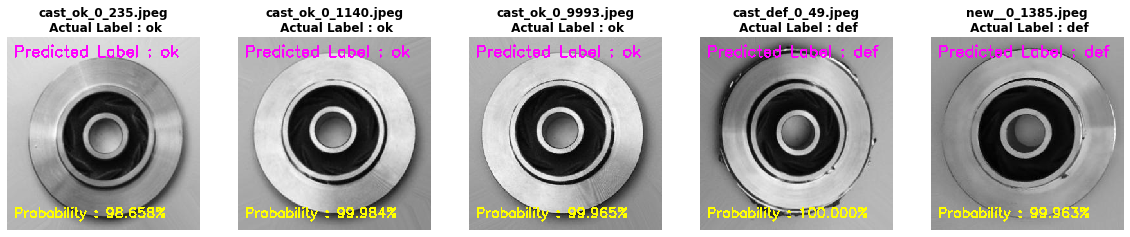

In [44]:
#predict on test images
test_cases = ['ok_front/cast_ok_0_235.jpeg', 'ok_front/cast_ok_0_1140.jpeg', 'ok_front/cast_ok_0_9993.jpeg',
              'def_front/cast_def_0_49.jpeg', 'def_front/new__0_1385.jpeg']


plt.figure(figsize=(20,8))
for i in range(len(test_cases)):
    img_pred = cv2.imread(test_path + test_cases[i], cv2.IMREAD_GRAYSCALE)
    #print ("test_case -> ",test_cases[i])
    #print ("test_case -> ",img_pred)
    img_pred = img_pred / 255 # rescale
    prediction = model.predict(img_pred.reshape(1, *image_shape))
    
    img = cv2.imread(test_path + test_cases[i])
    label = test_cases[i].split("_")[0]
    
    plt.subplot(2, 5, i+1)
    plt.title(f"{test_cases[i].split('/')[1]}\n Actual Label : {label}", weight='bold', size=12)
    if (prediction < 0.5):
        predicted_label = "def"
        prob = (1-prediction.sum()) * 100
    else:
        predicted_label = "ok"
        prob = prediction.sum() * 100
        
    cv2.putText(img=img, text=f"Predicted Label : {predicted_label}", org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(255, 0, 255), thickness=2)
    cv2.putText(img=img, text=f"Probability : {'{:.3f}'.format(prob)}%", org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(255, 255, 0), thickness=2)
    plt.imshow(img,cmap='gray')
    plt.axis('off')

plt.show()


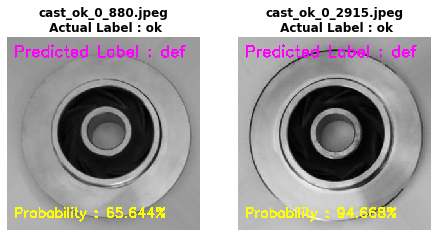

In [46]:
test_cases = ['ok_front/'+i for i in os.listdir('/data/casting_data/casting_data/casting_data/test/ok_front')]
test_cases.extend(['def_front/'+i for i in os.listdir('/data/casting_data/casting_data/casting_data/test/def_front')])

plt.figure(figsize=(20,8))
cnt = 0 
misclassified = []
for i in range(len(test_cases)):
    img_pred = cv2.imread(test_path + test_cases[i], cv2.IMREAD_GRAYSCALE)
    img_pred = img_pred / 255 # rescale
    prediction = model.predict(img_pred.reshape(1, *image_shape))
    
    img = cv2.imread(test_path + test_cases[i])
    label = test_cases[i].split("_")[0]
    
    if (prediction < 0.5):
        predicted_label = "def"
        prob = (1-prediction.sum()) * 100
    else:
        predicted_label = "ok"
        prob = prediction.sum() * 100
    
    if label != predicted_label:
        misclassified.append(test_cases[i])
        plt.subplot(2, 5, cnt+1)
        plt.title(f"{test_cases[i].split('/')[1]}\n Actual Label : {label}", weight='bold', size=12)
        cv2.putText(img=img, text=f"Predicted Label : {predicted_label}", org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(255, 0, 255), thickness=2)
        cv2.putText(img=img, text=f"Probability : {'{:.3f}'.format(prob)}%", org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(255, 255, 0), thickness=2)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        cnt += 1
    else:
        continue

plt.show()

In [47]:
#Explain Model
train_cases = ['ok_front/'+i for i in os.listdir('/data/casting_data/casting_data/casting_data/train/ok_front')]
train_cases.extend(['def_front/'+i for i in os.listdir('/data/casting_data/casting_data/casting_data/train/def_front')])
train_sample = [cv2.imread(train_path + i, cv2.IMREAD_GRAYSCALE).reshape(1, *image_shape) / 255 for i in np.random.choice(train_cases, 3000, replace=False)]
explainer = shap.DeepExplainer(model, train_sample[0])

Using TensorFlow backend.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


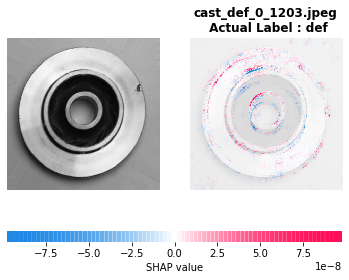

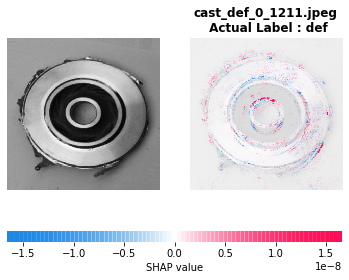

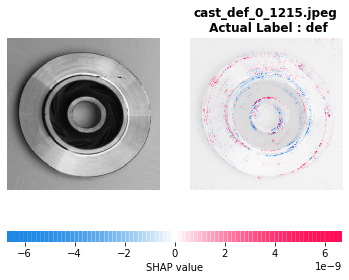

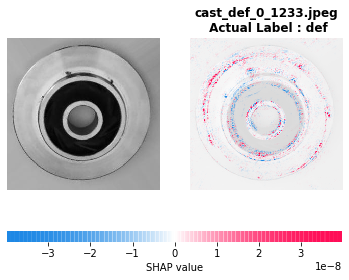

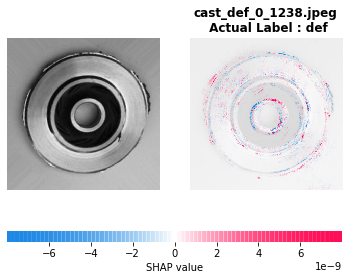

In [49]:
#Explain Correct Classification
test_cases = ['def_front/cast_def_0_1203.jpeg', 'def_front/cast_def_0_1211.jpeg', 'def_front/cast_def_0_1215.jpeg',\
              'def_front/cast_def_0_1233.jpeg', 'def_front/cast_def_0_1238.jpeg']

for i in test_cases:
    img = cv2.imread(test_path + i, cv2.IMREAD_GRAYSCALE).reshape(1, *image_shape) / 255
    shap_values = explainer.shap_values(img)
    shap.image_plot(shap_values, img, show=False) 
    plt.title(f"{i.split('/')[1]}\n Actual Label : {i.split('_')[0]}", weight='bold', size=12)
    plt.axis('off')
plt.show()

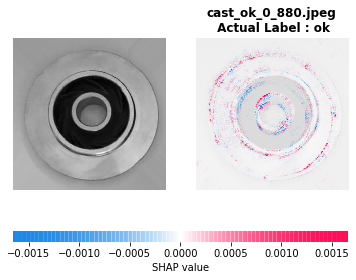

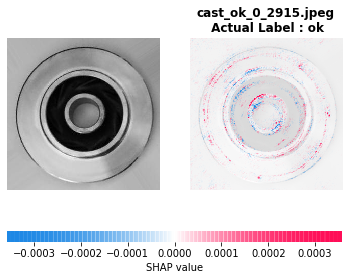

In [50]:
#Explain Misclassification
for i in misclassified:
    img = cv2.imread(test_path + i, cv2.IMREAD_GRAYSCALE).reshape(1, *image_shape) / 255
    shap_values = explainer.shap_values(img)
    shap.image_plot(shap_values, img, show=False) 
    plt.title(f"{i.split('/')[1]}\n Actual Label : {i.split('_')[0]}", weight='bold', size=12)
    plt.axis('off')
plt.show()

In [51]:
from connector.mosaicio import MosaicioConnector
ioConnector = MosaicioConnector()

from mosaicml import *
from mosaicml.constants import MLModelFlavours

from mosaicml import register_model, add_version

In [122]:
#Modified Score Function for new version
@scoring_func
def score(input_model, request):
    import PIL
    import numpy as np
    if request.method == 'POST':
        if 'file1' not in request.files:
            return 'No file part'
        file= request.files['file1']
        if file.filename == '':
            return 'No selected file'
        if file:
            image_shape = (300,300,1)
            image = PIL.Image.open(file)
            to_newscale = np.array(PIL.ImageOps.grayscale(image)) 
            to_numpy = np.expand_dims(to_newscale, axis = 0)
            to_numpy = to_numpy.reshape(300,300,-1)
            to_numpy = to_numpy.reshape(1,300,300,-1)
            p = input_model.predict(to_numpy) < 0.5
            if p:
                return "Defective"
            else:
                return "Good"

In [123]:
register_model_value = register_model(model_obj=model,
                                      scoring_func=score, 
                                      name="IndustrialImageDefectClassifier", 
                                      description="Industrial Machinery Defect Detection Model",
                                      flavour=MLModelFlavours.keras, 
                                      X_train =train_set, X_test = test_set, 
                                      y_train = train_set.classes, y_test = test_set.classes,
                                      y_true=test_set.classes, y_pred=predictions, prob=pred_probability,
                                      target_names = ["Defective","Good"],
                                      model_type="classification")
print("Registering model")

Calculating build time metrics

Progress: ██████████████████████████████████████████████████████████████████████ 100.0%


Registering model


In [107]:
#testing score function
import PIL
import numpy as np
image_shape = (300,300,1)
image = PIL.Image.open('/data/casting_data/casting_data/casting_data/train/def_front/cast_def_0_0.jpeg')
to_newscale = np.array(PIL.ImageOps.grayscale(image)) 
to_numpy = np.expand_dims(to_newscale, axis = 0)
to_numpy = to_numpy.reshape(300,300,-1)
to_numpy = to_numpy.reshape(1,300,300,-1)
model.predict(to_numpy)

(300, 300)
(1, 300, 300)
(300, 300, 1)
(1, 300, 300, 1)


array([[0.]], dtype=float32)